## Evaluate Text Summarization models using BBC news

#### BBC news classification
#### Automatic Summarization model evaluation
#### Use One-vs-the-rest (OvR) multiclass/multilabel strategy as strategy for multiclass classification

The objective of this article is to evaluate Text Summarization models by comparing classification accuracy before and after Text Summarization on BBC news.
three methods:
gensim.summarization
simple methods based on word frequency
control: random sampling

##  Import libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from numpy import random

import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd

import nltk
from nltk import Text
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.probability import FreqDist

from string import punctuation
from heapq import nlargest
from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import  SGDClassifier 
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import roc_curve, precision_recall_curve,auc
from sklearn.metrics import average_precision_score,cohen_kappa_score

from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
import gensim
from gensim.summarization import summarize
#from gensim.utils import lemmatize
from textblob import TextBlob
from textblob import Word

### Create dataframe from mulitiple data files. 
Data source: https://www.bonaccorso.eu/wp-content/uploads/2016/12/bbc.html

In [60]:
data_folder = "../bbc"
folders = ["business","entertainment","politics","sport","tech"]
try:
    os.chdir("../bbc")
except:
    os.chdir("./bbc")
    
x = []
y = []

for i in folders:
    files = os.listdir(i)
    for text_file in files:
        file_path = i + "/" + text_file
        with open(file_path) as f:
            lines = f.readlines()
        record = ' '.join(lines)
        x.append(record)
        y.append(i)   
data = {'news': x, 'type': y}       
df = pd.DataFrame(data)
df.to_csv('../bbc/dataset.csv', index=False)
print ('done writing csv flie')

done writing csv flie


## BBC news cleansing

In [61]:
news = pd.read_csv('../bbc/dataset.csv', delimiter=',',encoding = "ISO-8859-1")
# Associate Category names with numerical index and save it in new column category_id
news['category_id'] = news['type'].factorize()[0]
nRow, nCol = news.shape
nRow, nCol

(2225, 3)

In [62]:
# creation of the column count for aggregation
news['Count']=1
news[['type','Count']].groupby(['type'], as_index=False).count()

,type,Count
0,business,510
1,entertainment,386
2,politics,417
3,sport,511
4,tech,401


### Pretty balanced 

In [63]:
news.head(2)

,news,type,category_id,Count
0,Ad sales boost Time Warner profit\n \n Quarter...,business,0,1
1,Dollar gains on Greenspan speech\n \n The doll...,business,0,1


### Check the news length to make sure they are long enough for our purpose - evaluating text summarization

In [64]:
# keep all
news['newslen']=news['news'].apply(lambda x:len(x))
#news.sort_values(by='newslen', ascending=True) ##both ways work
news['newslen'].sort_values(axis=0, ascending=True)[0:10]

1292    507
1561    725
1515    733
1568    746
1319    747
1503    750
1818    761
1816    761
1810    764
1532    766
Name: newslen, dtype: int64

**Select text more than one sentence. Gensim will give error for one sentence text**

In [65]:
# Use RE to match text with only one appearance of . or ? or ! 
# [\w\W]* will match anything including return
news=news[news['news'].str.match(pat ='[\w\W]*[.?!][\w\W]*[.?!][\w\W]*')]
# Remove decimal part of a float number. Decimal point is treated as peroid when count sentences during summarization
news['news']=news['news'].str.replace('\.\d+', ' ', regex=True)
# add a space after '.' so Gensim will treat it as a sentence
news['news']=news['news'].str.replace('.', '. ', regex=False)
news['news']=news['news'].str.replace('?', '? ', regex=False)
news['news']=news['news'].str.replace('!', '! ', regex=False)


### Check any news only has one sentence 

In [66]:
news[~news['news'].str.match(pat ='[\w\W]*[.?!][\w\W]*[.?!][\w\W]*')]['news']

Series([], Name: news, dtype: object)

**Plot the count by type**

In [67]:
newsbyType=news.groupby('type', as_index=False).agg({"Count": "sum"})
newsbyType.head()

,type,Count
0,business,510
1,entertainment,386
2,politics,417
3,sport,511
4,tech,401


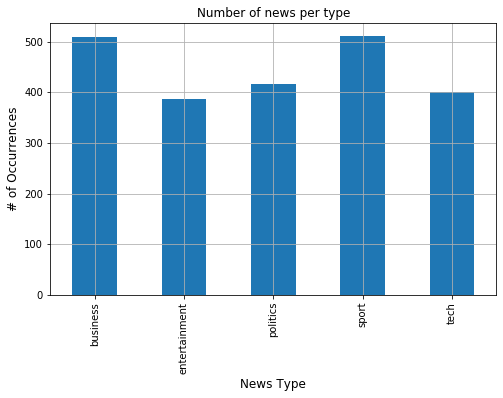

In [68]:
newsbyType.plot(x='type', y='Count', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of news per type")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('News Type', fontsize=12)
plt.show()

In [69]:
news['news'][:4]

0    Ad sales boost Time Warner profit\n \n Quarter...
1    Dollar gains on Greenspan speech\n \n The doll...
2    Yukos unit buyer faces loan claim\n \n The own...
3    High fuel prices hit BA's profits\n \n British...
Name: news, dtype: object

### Clean the news text field

In [70]:
# function for cleaning the plots of the movies
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = text.strip(' ')# remove the leading and trailing space
    letteronly = re.compile('[^a-z #+_]') # only keep letters and a few symbol.
    text = letteronly.sub(' ', text) 

    
    #lemmatize
    #lemmatized_out = [wd.decode('utf-8').split('/')[0] for wd in lemmatize(text)] # give error in python3.7

    sent = TextBlob(text)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    words  = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(words)


In [71]:
news['newsClean'] = news['news'].apply(clean_text)

In [72]:
news.newsClean[0:2].values

array(['ad sale boost time warner profit quarterly profit at u medium giant timewarner jump to bn m for the three month to december from m year earlier the firm which be now one of the big investor in google benefit from sale of high speed internet connection and high advert sale timewarner say fourth quarter sale rise to bn from bn it profit be buoy by one off gain which offset a profit dip at warner bros and less user for aol time warner say on friday that it now own of search engine google but it own internet business aol have have mix fortune it lose subscriber in the fourth quarter profit be low than in the preceding three quarter however the company say aol underlying profit before exceptional item rise on the back of strong internet advertising revenue it hop to increase subscriber by offer the online service free to timewarner internet customer and will try to sign up aol exist customer for high speed broadband timewarner also have to restate and result follow a probe by the u 

### get_dummies for target column

In [73]:
news=pd.get_dummies(data=news, columns=['type'])
news.columns

Index(['news', 'category_id', 'Count', 'newslen', 'newsClean', 'type_business',
       'type_entertainment', 'type_politics', 'type_sport', 'type_tech'],
      dtype='object')

## Model Training and Evaluation
### We will try 3 different classification models on the data : 
            LinearSVC
            SGDClassifier
            MultinomialNB (Naive Bayes)
### One-vs-the-rest (OvR) multiclass/multilabel strategy is the most commonly used strategy for multiclass classification and is a fair default choice.

In [74]:
X_train,X_test,y_train,y_test =  train_test_split(news['newsClean'],news.iloc[:,5:10], random_state=42, test_size=0.20, shuffle=True)

### Use pipeline link preprocessing TFIDF and model fitting in a proper way so no data leaking from test to train

In [75]:
def DoClassification (model,method):
    pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words ='english',min_df=8, smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')),
    ('clf', model)])
    if method=='predit':
        y_score = pipeline.fit(X_train, y_train).predict(X_test)
    elif method=='predit_proba':
        y_score = pipeline.fit(X_train, y_train).predict_proba(X_test)
    elif method=='decision_function':
        y_score = pipeline.fit(X_train, y_train).decision_function(X_test)
    return(y_score )

### Create a dataframe to hold all scores

In [76]:
accuracy_classifier= pd.DataFrame(columns = ['type']) 

### Compute performance metrics for each class

In [77]:
def computeMetrics (metrics,y_score,classifiername):
    score = dict()
    for i in range(len(y_train.columns)):
        score[i] = metrics(y_test.iloc[:,i], y_score[:,i])
        accuracy_classifier.loc[i,'type'] = y_train.columns[i]
        accuracy_classifier.loc[i,classifiername+'_'+ metrics.__name__]=score[i]

### MultinomialNB

** Average_precision_score is used since it handles unbalanced classes well. roc_auc_score and cohen_kappa_score can be tried for comparison. Cohen’s kappa statistic is a very good measure that can handle well both multi-class and imbalanced class problems. **

In [78]:
### Multinomial Naive Bayes
classifier =OneVsRestClassifier(MultinomialNB())
y_score=DoClassification(classifier,'predit_proba' )
computeMetrics(average_precision_score,y_score,'multinomialNB')

### Linear Support Vector Classifier

In [79]:
classifier=OneVsRestClassifier(LinearSVC(), n_jobs=1)
y_score=DoClassification(classifier,'predit' )
computeMetrics(average_precision_score,y_score,'LinearSVC')

### SGDClassifier 
**faster than LinearSVC**

In [80]:
classifier=OneVsRestClassifier(SGDClassifier(), n_jobs=1)
y_score=DoClassification(classifier,'decision_function' )
computeMetrics(average_precision_score,y_score,'SGDClassifier')

In [81]:
accuracy_classifier

,type,multinomialNB_average_precision_score,LinearSVC_average_precision_score,SGDClassifier_average_precision_score
0,type_business,0.912010,0.892585,0.971753
1,type_entertainment,0.967122,0.928107,0.963583
2,type_politics,0.883380,0.941654,0.964069
3,type_sport,0.999905,0.982735,0.998127
4,type_tech,0.908059,0.956902,0.960112


### SGDClassifier has highest scores. Will use it in later steps to evaluate Summarization models

### Evaluate Text Summarization models

**Gensim**

In [82]:
news.shape

(2225, 10)

In [83]:
news['newsSum']=news['news'].apply(lambda x:summarize(x,ratio=0.15)) ## default ratio=0.2

**Take a look at the Summarization**

In [84]:
news['news'].iloc[55:56].values


array(['BMW drives record sales in Asia\n \n BMW has forecast sales growth of at least 10% in Asia this year after registering record sales there in 2004. \n \n The luxury carmaker saw strong sales of its three marques - BMW, Mini and Rolls-Royce - in Asia last year after the launch of three new models.  The company, which is vying with Mercedes-Benz for the title of leading premium carmaker, is confident about its prospects for the region in 2005.  It is launching a revamped version of its 3-Series saloon class next month. \n \n BMW sold nearly 95,000 cars in Asia last year, up 2 % on 2003. \n \n BMW-brand sales rose 2 % to 80,600 while sales of Mini models rose 3 % to 14,800.  There was also a significant increase in sales of Rolls-Royces on the continent.  BMW sold more than 100 of the iconic models compared with just ten the previous year.  The German carmaker is aiming to boost annual sales in Asia to 150,000 by 2008.  "Here in Asia, we consider a double-digit increase in retail o

In [85]:
news['newsSum'].iloc[55:56].values

array(['The luxury carmaker saw strong sales of its three marques - BMW, Mini and Rolls-Royce - in Asia last year after the launch of three new models.\nBMW-brand sales rose 2 % to 80,600 while sales of Mini models rose 3 % to 14,800.'],
      dtype=object)

### Clean the Summarization text field

In [86]:
news['newsSumClean'] = news['newsSum'].apply(clean_text)

In [87]:
news['newsSumClean'].iloc[55:56].values

array(['the luxury carmaker saw strong sale of it three marque bmw mini and roll royce in asia last year after the launch of three new model bmw brand sale rise to while sale of mini model rise to'],
      dtype=object)

### Repeat the classifier evaluation using SGDClassifier on Summarization text using gensim summarizer

In [88]:
X_train,X_test,y_train,y_test =  train_test_split(news['newsSumClean'],news.iloc[:,5:10], random_state=42, test_size=0.20, shuffle=True)

In [90]:
classifier=OneVsRestClassifier(SGDClassifier(), n_jobs=1)
y_score=DoClassification(classifier,'decision_function' )
computeMetrics(average_precision_score,y_score,'SGD_Sum')

In [91]:
accuracy_classifier

,type,multinomialNB_average_precision_score,LinearSVC_average_precision_score,SGDClassifier_average_precision_score,SGD_Sum_average_precision_score
0,type_business,0.912010,0.892585,0.971753,0.916106
1,type_entertainment,0.967122,0.928107,0.963583,0.855703
2,type_politics,0.883380,0.941654,0.964069,0.900686
3,type_sport,0.999905,0.982735,0.998127,0.950188
4,type_tech,0.908059,0.956902,0.960112,0.934869


### A simple summarizer using sentence ranking=sum(word frequency) to select top sentences with high ranking. Can be customized to more complex calculation

In [92]:
def read_file(path):
    """ Read the file at designated path and throw exception if unable to do so """ 
    try:
        with open(path, 'r') as file:
            return file.read()

    except IOError as e:
        print("Fatal Error: File ({}) could not be locaeted or is not readable.".format(path))

def tokenize_content(content):
    """
    Accept the content and produce a list of tokenized sentences, 
    a list of tokenized words, and then a list of the tokenized words
    with stop words built from NLTK corpus and Python string class filtred out. 
    """
    stop_words =stopwords.words('english')
    words = word_tokenize(content) 
    return [
        sent_tokenize(content),
        [word for word in words if word not in stop_words]    
    ]

def score_tokens(filterd_words, sentence_tokens):
    """
    Builds a frequency map based on the filtered list of words and 
    uses this to produce a map of each sentence and its total score
    """
    word_freq = FreqDist(filterd_words)

    ranking = defaultdict(int)

    for i, sentence in enumerate(sentence_tokens):
        for word in word_tokenize(sentence.lower()):
            if word in word_freq:
                ranking[i] += word_freq[word]

    return ranking

def simplesummarize(content):
    """
    Utilizes a ranking map produced by score_token to extract
    the highest ranking sentences in order after converting from
    array to string.  
    """
    ranks=score_tokens(tokenize_content(content)[1], tokenize_content(content)[0])
    sentences=tokenize_content(content)[0]
    l= lambda x: int(len(x) * 0.15) if int(len(x) * 0.15) >=1 else 1 ## at least one sentence  
    length=l(sentences)
    indexes = nlargest(length, ranks, key=ranks.get)
    final_sentences = [sentences[j] for j in sorted(indexes)]
    return ' '.join(final_sentences) 

def randomsample(content):
    """
    Baseline summarizer
    Randomly select 15% sentences.  
    """
    sentences=tokenize_content(content)[0]
    l= lambda x: int(len(x) * 0.15) if int(len(x) * 0.15) >=1 else 1 ## at least one sentence  
    length=l(sentences)
    indexes = random.choice(list(range(len(sentences))), length)
    final_sentences = [sentences[j] for j in sorted(indexes)]
    return ' '.join(final_sentences)

### Repeat the classifier evaluation using SGDClassifier on Summarization text using simple summarizer

In [93]:
news['newsSumSimple'] = news['news'].apply(simplesummarize)

### Compare Summarization between Gensim and simple summarizer

In [94]:
news['newsSumSimple'].iloc[2:3].values

array(['Yukos unit buyer faces loan claim\n \n The owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (Ã\x82Â£479m) loan.'],
      dtype=object)

In [95]:
news['newsSum'].iloc[2:3].values

array(['State-owned Rosneft bought the Yugansk unit for $9 bn in a sale forced by Russia to part settle a $27 bn tax claim against Yukos.'],
      dtype=object)

In [96]:
news['SumSimpleClean'] =news['newsSumSimple'].apply(clean_text)

In [97]:
X_train,X_test,y_train,y_test =  train_test_split(news['SumSimpleClean'],news.iloc[:,5:10], random_state=42, test_size=0.20, shuffle=True)

In [98]:
classifier=OneVsRestClassifier(SGDClassifier(), n_jobs=1)
y_score=DoClassification(classifier,'decision_function' )
computeMetrics(average_precision_score,y_score,'SGD_Simp')

In [99]:
accuracy_classifier

,type,multinomialNB_average_precision_score,LinearSVC_average_precision_score,SGDClassifier_average_precision_score,SGD_Sum_average_precision_score,SGD_Simp_average_precision_score
0,type_business,0.912010,0.892585,0.971753,0.916106,0.878020
1,type_entertainment,0.967122,0.928107,0.963583,0.855703,0.902977
2,type_politics,0.883380,0.941654,0.964069,0.900686,0.861711
3,type_sport,0.999905,0.982735,0.998127,0.950188,0.934880
4,type_tech,0.908059,0.956902,0.960112,0.934869,0.883719


### Repeat the classifier evaluation using SGDClassifier on Summarization text using Random summarizer

In [100]:
news['Randomsample'] = news['news'].apply(randomsample)

In [101]:
news['Randomsample'].iloc[2:3].values

array(['Yukos had filed for bankruptcy protection in a US court in an attempt to prevent the forced sale of its main production arm.'],
      dtype=object)

In [102]:
news['RandomsampleClean'] = news['Randomsample'].apply(clean_text)

In [103]:
X_train,X_test,y_train,y_test =  train_test_split(news['RandomsampleClean'],news.iloc[:,5:10], random_state=42, test_size=0.20, shuffle=True)

In [104]:
classifier=OneVsRestClassifier(SGDClassifier(), n_jobs=1)
y_score=DoClassification(classifier,'decision_function' )
computeMetrics(average_precision_score,y_score,'SGD_Rand')

In [105]:
accuracy_classifier

,type,multinomialNB_average_precision_score,LinearSVC_average_precision_score,SGDClassifier_average_precision_score,SGD_Sum_average_precision_score,SGD_Simp_average_precision_score,SGD_Rand_average_precision_score
0,type_business,0.912010,0.892585,0.971753,0.916106,0.878020,0.811873
1,type_entertainment,0.967122,0.928107,0.963583,0.855703,0.902977,0.738625
2,type_politics,0.883380,0.941654,0.964069,0.900686,0.861711,0.788775
3,type_sport,0.999905,0.982735,0.998127,0.950188,0.934880,0.890088
4,type_tech,0.908059,0.956902,0.960112,0.934869,0.883719,0.841515


In [113]:
accuracy_classifier_melt = accuracy_classifier.melt(id_vars='type').rename(columns=str.title)
accuracy_classifier_melt

,Type,Variable,Value
0,type_business,multinomialNB_average_precision_score,0.912010
1,type_entertainment,multinomialNB_average_precision_score,0.967122
2,type_politics,multinomialNB_average_precision_score,0.883380
3,type_sport,multinomialNB_average_precision_score,0.999905
4,type_tech,multinomialNB_average_precision_score,0.908059
5,type_business,LinearSVC_average_precision_score,0.892585
6,type_entertainment,LinearSVC_average_precision_score,0.928107
7,type_politics,LinearSVC_average_precision_score,0.941654
8,type_sport,LinearSVC_average_precision_score,0.982735
9,type_tech,LinearSVC_average_precision_score,0.956902


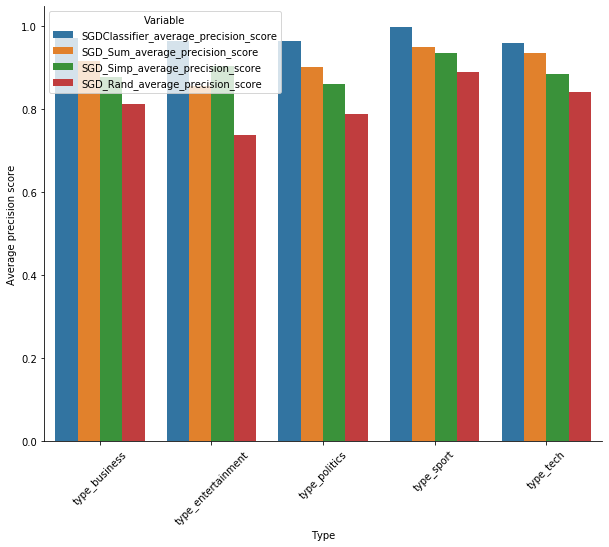

In [114]:
accuracy_classifier_melt.dropna(inplace=True)
fig, ax1 = plt.subplots(figsize=(10, 8))
type=sns.barplot(x='Type', y='Value', hue='Variable', data=accuracy_classifier_melt[-20:])
for item in type.get_xticklabels():
    item.set_rotation(45)
ax1.set(xlabel='Type', ylabel='Average precision score')
sns.despine(fig)

### Ratio of classification accuracy after summarization by Gensim vs original news 

In [116]:
accuracy_classifier.SGD_Sum_average_precision_score.mean()/accuracy_classifier.SGDClassifier_average_precision_score.mean()

0.93822235218252

### Ratio of classification accuracy after summarization by simple summarization vs original news 

In [117]:
accuracy_classifier.SGD_Simp_average_precision_score.mean()/accuracy_classifier.SGDClassifier_average_precision_score.mean()

0.9184092720562261

### Ratio of classification accuracy after random sencence selection vs original news 

In [118]:
accuracy_classifier.SGD_Rand_average_precision_score.mean()/accuracy_classifier.SGDClassifier_average_precision_score.mean()

0.8380349731183301

In [119]:
accuracy_classifier.to_csv('NewsPerformMetrics.csv')

### Conclusion: Summarization using Gensim is effective- key information is preserved so that accuracy of news classification using original news and news summarization is similar.
### Simple summarizer is not as good as Gensim. Both are a lot better than random sampling. 